#### 01 - Import Libraries

In [54]:
import pandas as pd
import numpy as np
import pandas_profiling as pp
import seaborn as sns
from sklearn import linear_model


#### 02 - Read in and get an overview of the data

In [55]:
racc = pd.read_csv('road-accidents.csv',sep='|',skiprows=9)
mdriv = pd.read_csv('miles-driven.csv',sep='|')

In [56]:
df = pd.merge(racc, mdriv, on='state')
df.head()

,state,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time,million_miles_annually
0,Alabama,18.8,39,30,80,64914
1,Alaska,18.1,41,25,94,4593
2,Arizona,18.6,35,28,96,59575
3,Arkansas,22.4,18,26,95,32953
4,California,12.0,35,28,89,320784


#### 03 - Create a textual and a graphical summary of the data

In [57]:
df_prof = pp.ProfileReport(df, title="Road Accedants and Miles Driven")
df_prof

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

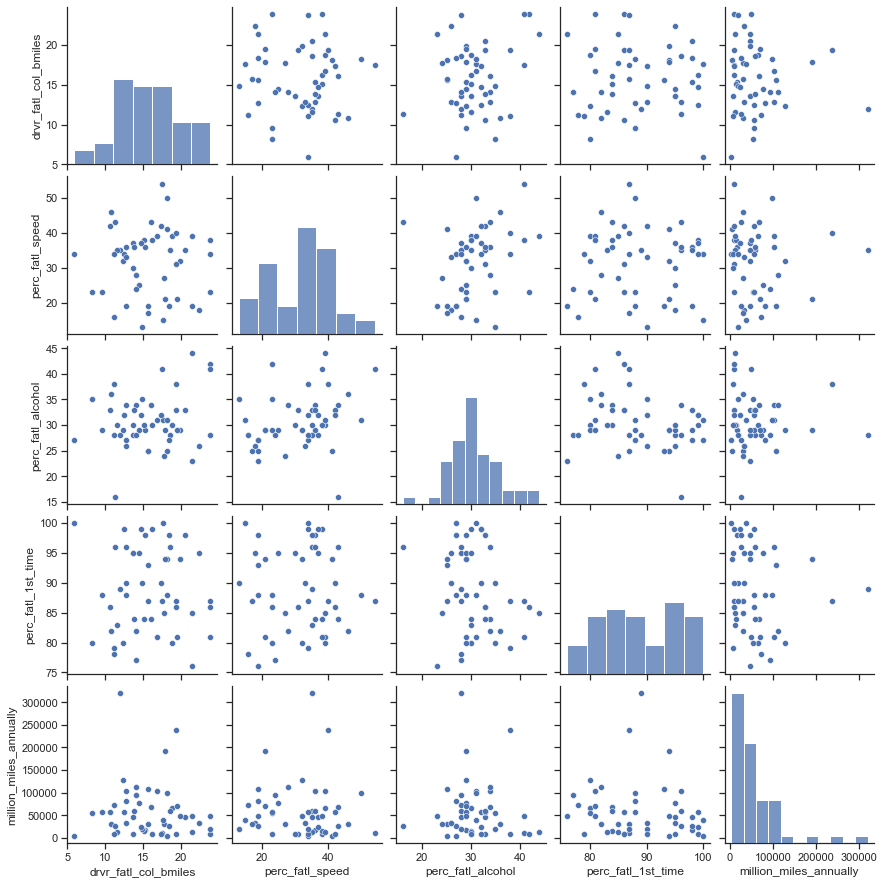

In [58]:
sns.set_theme(style="ticks")
sns.pairplot(df)

#### 04 - Quantify the association of features and accidents

In [59]:
df_corr = df.corr()
df_corr

,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time,million_miles_annually
drvr_fatl_col_bmiles,1.000000,-0.029080,0.199426,-0.017942,-0.077133
perc_fatl_speed,-0.029080,1.000000,0.286244,0.014066,-0.043199
perc_fatl_alcohol,0.199426,0.286244,1.000000,-0.245455,-0.034561
perc_fatl_1st_time,-0.017942,0.014066,-0.245455,1.000000,-0.128928
million_miles_annually,-0.077133,-0.043199,-0.034561,-0.128928,1.000000


#### 05 - Fit a multivariate linear regression

In [60]:
y = df.iloc[:,1:2]
X = df.iloc[:,2:5]

In [61]:
model = linear_model.LinearRegression().fit(X,y)

In [62]:
print(model.coef_)

[[-0.04180041  0.19086404  0.02473301]]


In [63]:
print(df_corr.iloc[:1,1:4])

                      perc_fatl_speed  perc_fatl_alcohol  perc_fatl_1st_time
drvr_fatl_col_bmiles         -0.02908           0.199426           -0.017942


#### 06 - Perform PCA on standardized data

The cumulative variance of the first two principal componenets is 0.7947


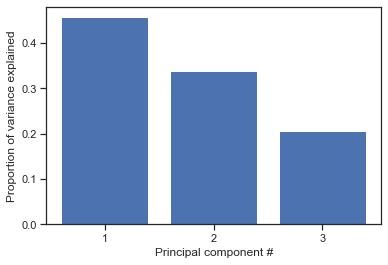

In [64]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.decomposition import PCA
pca = PCA()

pca.fit(X_scaled)

import matplotlib.pyplot as plt
plt.bar(range(1, pca.n_components_ + 1),  pca.explained_variance_ratio_)
plt.xlabel('Principal component #')
plt.ylabel('Proportion of variance explained')
plt.xticks([1, 2, 3])

two_first_comp_var_exp = pca.explained_variance_ratio_.cumsum()[1]
print("The cumulative variance of the first two principal componenets is {}".format(
    round(two_first_comp_var_exp, 5)))

#### 07 - Visualize the first two principal components

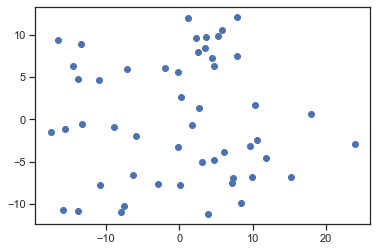

In [65]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)
X_pca_1 = X_pca[:, 0]
X_pca_2 = X_pca[:, 1]
plt.scatter(X_pca_1, X_pca_2)

#### 08 - Find clusters of similar states in the data

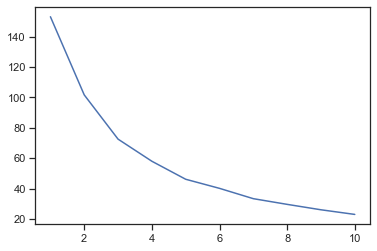

In [66]:
from sklearn.cluster import KMeans
inertia = []
for i in range(1, 11):
    k = KMeans(n_clusters=i, random_state= 0).fit(X_scaled)
    inertia.append(k.inertia_)
plt.plot(range(1, 11), inertia)

#### 09 - KMeans to visualize clusters in the PCA scatter plot

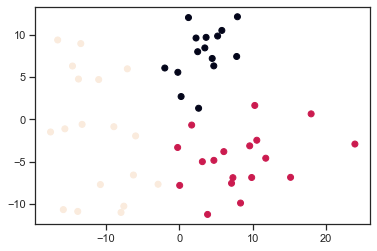

In [67]:
k = KMeans(n_clusters= 3, random_state= 0).fit(X_pca)
plt.scatter(X_pca_1, X_pca_2, c = k.labels_)

#### 10 - Visualize the feature differences between the clusters

<AxesSubplot:xlabel='percent', ylabel='measurement'>

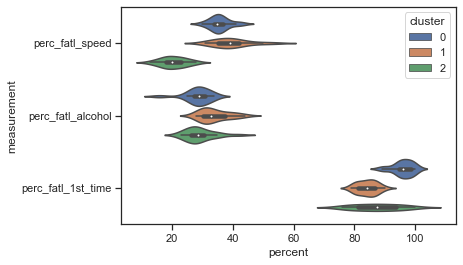

In [68]:
X['cluster'] = k.labels_

melt_car = pd.melt(X, id_vars='cluster', var_name='measurement', value_name='percent',
                   value_vars=['perc_fatl_speed', 'perc_fatl_alcohol', 'perc_fatl_1st_time'])

sns.violinplot(y='measurement', x='percent', data=melt_car, hue='cluster')

#### 11 - Compute the number of accidents within each cluster

In [69]:
df['cluster'] = k.labels_

In [70]:
df['drvr_fatl_col'] = df['drvr_fatl_col_bmiles']* df['million_miles_annually'] / 1000
df.head()

,state,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time,million_miles_annually,cluster,drvr_fatl_col
0,Alabama,18.8,39,30,80,64914,1,1220.3832
1,Alaska,18.1,41,25,94,4593,0,83.1333
2,Arizona,18.6,35,28,96,59575,0,1108.0950
3,Arkansas,22.4,18,26,95,32953,2,738.1472
4,California,12.0,35,28,89,320784,0,3849.4080


,count,mean,sum
cluster,,,
0,15,745.600367,11184.0055
1,18,923.909733,16630.3752
2,18,990.046094,17820.8297


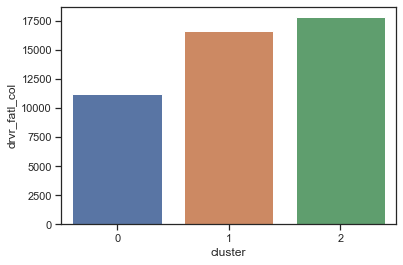

In [71]:
# Create a barplot of the total number of accidents per cluster
sns.barplot(x='cluster', y='drvr_fatl_col', data=df, estimator=sum, ci=None)

# Calculate the number of states in each cluster and their 'num_drvr_fatl_col' mean and sum.
count_mean_sum = df.groupby('cluster')['drvr_fatl_col'].agg(['count', 'mean', 'sum'])
count_mean_sum

### We would choose cluster number 0